## Amazon Fine Food Reviews
In this project, we have a dataset of size 568K * 10. The 10 features are as follows:
1. Id
2. ProductId
3. UserId
4. ProfileName
5. HelpfulnessNumerator
6. HelpfulnessDenominator
7. Score
8. Time
9. Summary
10. Text

The objective of this project is to predict whether a review is positive or negative (Binary Clssification).

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
con = sqlite3.connect("D:/[FCO] AppliedAICourse - Applied Machine Learning Course/1.0 CSV files/Amazon fine food reviews/database.sqlite")

#Score = 1 or 2 means review would be negative and Score = 3 or 5 means review would be positive. Hence, Score = 3 is neglected. 
data = pd.read_sql_query("""
       SELECT * from Reviews
       where Score != 3""" , con)

print(data.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [4]:
def partition(x):
    if x > 3:
        return 'positive'
    else:
        return 'negative'

actualScore = data['Score']
positiveNegative = actualScore.map(partition)
data['Score'] = positiveNegative

In [4]:
print(data.head())
print(data.shape)

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitalit

In [5]:
display = pd.read_sql_query("""
        SELECT * FROM Reviews 
        WHERE Score != 3 AND UserId = 'AR5J8UI46CURR'
        ORDER BY ProductId
        """ , con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


Observations: 1) As in above table, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator.Score,Time, Summary and Text shows same content 2) Also for all 5 product, shows same time. 3) Here we observed that, product is same, only the flavour is different 4) so we will remove this duplication and keep any one product which all these features so we removing duplicates.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data = data.sort_values('ProductId' , axis = 0 , inplace = False , ascending = True)
final = sorted_data.drop_duplicates(subset = {'UserId' , 'ProfileName' , 'Time' , 'Text'} , keep = 'first' , inplace = False)
final.shape

(364173, 10)

In [7]:
#Keeping only those data points where HelpfulnessNumerator is greater than or equal to HelpfulnessDenominator
#as HelpfulnessNumerator cannot be greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [8]:
print((final.Score.size / sorted_data.Score.size) * 100)

69.25852107399194


In [8]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [9]:
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr , '' , sentence)
    return cleantext

def clearpunc(sentence):
    cleaned = re.sub(r'[? | ! | \' | " | #]' , r'' , sentence)
    cleaned = re.sub(r'[. | , | ) | ( | \ | / | : | ; | < | >]' , r'' , cleaned)
    return cleaned

In [10]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')
print(stop)

{'did', 'ours', 'and', 'some', 'my', 'him', 't', 'until', 'such', "it's", 'to', "hadn't", 'by', 'he', 'being', 'has', "haven't", "she's", 'over', 'during', 'at', 'most', 'will', 'about', 'now', 'but', 'same', 'your', 'his', 'more', 'didn', 'wouldn', 'again', 'having', "aren't", "mustn't", "weren't", 've', "that'll", 'we', 'once', 'through', "wasn't", 'both', 'no', 'does', 'in', 'own', 'then', 'be', 'who', 'ma', "you've", 'do', 'hadn', 'yours', 'than', 'only', 'm', 'shan', 'how', 'whom', 'ain', 'nor', 'is', 'so', 'here', 'are', 'very', 'hasn', 'that', 'she', 'aren', 'd', 'further', 'this', 'mightn', 'not', 'should', 'had', "needn't", 'above', 'they', 'why', 'on', 'off', "isn't", "you'll", 'y', 'won', 'a', 'shouldn', "shan't", 'with', 'doing', 'from', 'its', "mightn't", 'haven', 'there', 'weren', "don't", 'because', 'as', 'after', 'few', 'each', 're', 'i', 'those', 'itself', 'when', 'before', 'hers', 'below', 'theirs', 'all', 'down', 'an', 'out', 'against', 'while', 'what', 'been', 'isn'

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 364k sentences.
i = 0
str1 = ' '
finalString = []
all_positive_words = []
all_negative_words = []
s = ''

for sent in final['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleanedwords in clearpunc(w).split():
            if((cleanedwords.isalpha()) & (len(cleanedwords) > 2)):
                if(cleanedwords.lower() not in stop):
                    s = (sno.stem(cleanedwords.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                        
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                        
                else:
                    continue
            else:
                continue
                
    str1 = b" ".join(filtered_sentence)
    
    finalString.append(str1)
    i += 1

In [ ]:
print(finalString)

In [12]:
# Adding a column of CleanedText which shows data after preprocessing the reviews 
final['Cleaned Text'] = finalString

In [13]:
X1 = final[final['Score'] == 'positive'].sample(n = 10000 , random_state = 0)
X2 = final[final['Score'] == 'negative'].sample(n = 10000 , random_state = 0) 
X = pd.concat([X1 , X2])

In [14]:
#Time-Based Splitting
X['Time'] = pd.to_datetime(X['Time'] , origin = 'unix' , unit = 's')
X = X.sort_values('Time')
sampled_points = X['Cleaned Text']
Y = X['Score']

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix

In [26]:
# Function to compute optimal k value
def k_classifier_brute(XTrain , YTrain):
    neighbors = list(range(21 , 82 , 4))
    cv_score = []
    # 10 Fold Cross Validation for k
    for i in neighbors:
        neigh = KNeighborsClassifier(n_neighbors = i , algorithm = 'brute')
        scores = cross_val_score(neigh , XTrain , YTrain , cv = 10 , scoring = 'accuracy')
        cv_score.append(scores.mean())
    MSE = [1 - x for x in cv_score] # Misclassification Error
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\n Optimal number of neighbors = {}'.format(optimal_k))
    print('\n Misclassification Error for each k is {}'.format(np.round(MSE , 3)))
    plt.plot(neighbors, MSE) # 
    plt.title("Number of neighbors and error")
    plt.xlabel("Number of neighbors")
    plt.ylabel("Misclassification error")
    plt.show()
    return optimal_k

In [20]:
#Splitting the data into Train and Test datasets
XTrain, XTest, YTrain, YTest = train_test_split(sampled_points, Y, test_size = 0.3, random_state = 42) 

In [21]:
#Train Vectorizer
bow = CountVectorizer()
XTrain = bow.fit_transform(XTrain)

#Test Vectorizer
XTest = bow.transform(XTest)


 Optimal number of neighbors = 25

 Misclassification Error for each k is [0.307 0.306 0.31  0.314 0.316 0.322 0.323 0.327 0.329 0.331 0.333 0.335
 0.336 0.337 0.34  0.342]


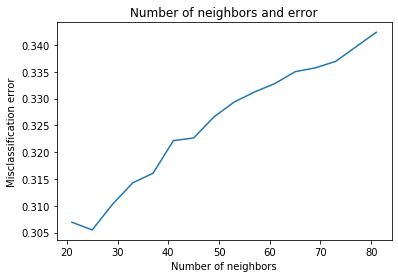

In [27]:
#To chose optial k using brute force algorithm
optimal_k_bow = k_classifier_brute(XTrain , YTrain)

In [30]:
# instantiate the KNN model with k = optimal k
knn_optimal_for_bow = KNeighborsClassifier(n_neighbors = optimal_k_bow)

# fitting the mode to training dataset
knn_optimal_for_bow.fit(XTrain , YTrain)

#Predicting the response
pred = knn_optimal_for_bow.predict(XTest)

In [33]:
#Accuracy on training data
train_accuracy = knn_optimal_for_bow.score(XTrain , YTrain)
print('\n Train Accuracy is ' , train_accuracy)

#Error on training data
train_error = 1 - train_accuracy
print('\n Train Error ', train_error)

#Evaluate accuracy on tet data
accuracy = accuracy_score(YTest , pred)
print('\n The accuracy score for k = {} is {}'.format(optimal_k_bow,accuracy))


 Train Accuracy is  0.7365

 Train Error  0.26349999999999996

 The accuracy score for k = 25 is 0.7001666666666667


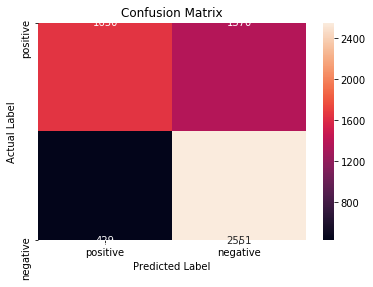

In [35]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(YTest , pred)
labels = ['positive' , 'negative']
df_cm = pd.DataFrame(cm , index = labels , columns = labels)

#pPotting the Confusion Matrix to describe the performance of the classifier
sns.heatmap(df_cm , annot = True , fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [36]:
# Main Classification Report
from sklearn.metrics import classification_report
print(classification_report(YTest , pred))

              precision    recall  f1-score   support

    negative       0.79      0.55      0.65      3020
    positive       0.65      0.86      0.74      2980

    accuracy                           0.70      6000
   macro avg       0.72      0.70      0.69      6000
weighted avg       0.72      0.70      0.69      6000



Observations:
1) From above figure(misclassification error vs optimal k), it is showing that classification error for each value of k, when k increases the error also increses.
2) As I tested our model on unseen data(test data) the accuracy is 70.0167% when k = 25.


# TF-IDF 

In [37]:
sampled_points = X['Cleaned Text']
Y = X['Score']

In [38]:
XTrain, XTest, YTrain, YTest = train_test_split(sampled_points, Y, test_size = 0.3, random_state = 42)

In [39]:
#Converting training text data to its vectorizer
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2))
XTrain = tf_idf_vect.fit_transform(XTrain)

#Converting test test data to its vectorizer 
XTest = tf_idf_vect.transform(XTest)


 Optimal number of neighbors = 81

 Misclassification Error for each k is [0.26  0.253 0.251 0.245 0.243 0.238 0.237 0.236 0.232 0.23  0.226 0.223
 0.224 0.22  0.221 0.218]


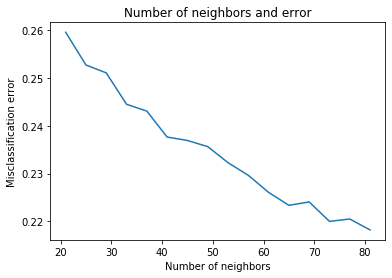

In [40]:
#selecting optimal k
optimal_k_tf_idf = k_classifier_brute(XTrain , YTrain)

In [41]:
# instantiate the KNN model with k = optimal k
knn_optimal_for_tf_idf = KNeighborsClassifier(n_neighbors = optimal_k_tf_idf)

# fitting the mode to training dataset
knn_optimal_for_tf_idf.fit(XTrain , YTrain)

# predicting the response
pred = knn_optimal_for_tf_idf.predict(XTest)

In [42]:
#Accuracy on training data
train_accuracy = knn_optimal_for_tf_idf.score(XTrain , YTrain)
print('\n Train Accuracy is ' , train_accuracy)

#Error on training data
train_error = 1 - train_accuracy
print('\n Train Error ', train_error)

#Evaluting accuracy on test ddata
accuracy = accuracy_score(YTest , pred)
print('\n The accuracy score for k = {} is {}'.format(optimal_k_tf_idf,accuracy))


 Train Accuracy is  0.797

 Train Error  0.20299999999999996

 The accuracy score for k = 81 is 0.7873333333333333


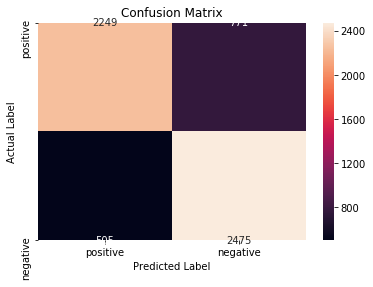

In [43]:
#plotting the confusion matrix to describe the performance of the classifier
cm = confusion_matrix(YTest , pred)
labels = ['positive' , 'negative']
df_cm = pd.DataFrame(cm , index = labels , columns = labels)
sns.heatmap(df_cm , annot = True , fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [44]:
print(classification_report(YTest , pred))

              precision    recall  f1-score   support

    negative       0.82      0.74      0.78      3020
    positive       0.76      0.83      0.80      2980

    accuracy                           0.79      6000
   macro avg       0.79      0.79      0.79      6000
weighted avg       0.79      0.79      0.79      6000



Observations:
1) Optimal k is 81 with tet accuracy = 78.74%
2) From Confusion matrix, model predicted 3246 as negative & actual negative are 2980 and predicted 2754 as positive & actual positive are 3020 which is quite good.
3) So we can say that, this model works well